# Evaluation of intended filters

Here we want to find out which filter (Gaussian or Bilateral) works best in comparison to the unfiltered images using the Dice score and the image Otsu_t13.tiff

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os # To save images
from matplotlib import colors # To convert image models
import cv2 as cv2 # To apply filters

In [6]:
#from Functions.KMeans import split_channels
#from Functions.KMeans import init_centroids
#from Functions.KMeans import euclidean_distance_3d
#from Functions.KMeans import assign_to_centroids_kdtree
#from Functions.KMeans import update_centroids
#from Functions.KMeans import kmeans_clusteringGrayscale_kdtree
#import os
from Functions.FinalKMeans import preprocess_rgb
from Functions.FinalKMeans import preprocess_grayscale
from Functions.FinalKMeans import preprocess_hsv
from Functions.FinalKMeans import preprocess_image
from Functions.FinalKMeans import init_centroids
from Functions.FinalKMeans import assign_to_centroids
from Functions.FinalKMeans import update_centroids
from Functions.FinalKMeans import kmeans
from Functions.FinalKMeans import reconstruct_segmented_image
from Functions.FinalKMeans import save_image
from Functions.FinalKMeans import save_image_universal
from Functions.Datenvorbereitung import apply_median_filter 

In [7]:
#Normalisiert grayscale
#def normalize_grayscale(image):
 #   """
  #  Normalisiert ein Graustufenbild auf Werte zwischen 0 und 1 (float).
   # """
    #image = image.astype(float)
    #norm_img = (image - image.min()) / (image.max() - image.min())
    #return norm_img

In [13]:
gray_t13_bilateral = np.copy(plt.imread('Images/Datenvorbereitung_images/Otsu/Filtered_t13/t13_bilateral.tiff'))
gray_t13_gauß = np.copy(plt.imread('Images/Datenvorbereitung_images/Otsu/Filtered_t13/t13_gauß.tiff'))
gray_t13_median = apply_median_filter(np.copy(plt.imread('Original_Images/Otsu/Data/N2DL-HeLa/img/t13.tif')), kernel = 5)
gray_t13 = np.copy(plt.imread('Original_Images/Otsu/Data/N2DL-HeLa/img/t13.tif'))






In [9]:
#def init_centroids(features, k, random_seed=None):
 #   """
  #  Initialisiert k Zentroiden zufällig aus den Feature-Vektoren.
   # """
    #np.random.seed(random_seed)
    #indices = np.random.choice(features.shape[0], k, replace=False)
    #return features[indices]

#def euclidean_distance(a, b):
 #   """
  #  Berechnet die euklidische Distanz zwischen zwei Arrays a und b.
   # a: (n_samples, n_features)
    #b: (k, n_features)
    #Rückgabe: (n_samples, k)
    #"""
    #return np.linalg.norm(a[:, None] - b[None, :], axis=-1)

#def assign_to_centroids(features, centroids):
 #   """
  #  Ordnet jedem Feature den nächsten Zentroiden zu.
   # """
    #dists = euclidean_distance(features, centroids)
    #return np.argmin(dists, axis=1)

#def update_centroids(features, labels, k):
 #   """
  #  Aktualisiert die Zentroiden als Mittelwert der zugeordneten Features.
   # """
    #new_centroids = []
    #for i in range(k):
     #   cluster_points = features[labels == i]
      #  if len(cluster_points) > 0:
       #     new_centroids.append(cluster_points.mean(axis=0))
        #else:
            # Falls ein Cluster leer ist, wähle zufällig einen Punkt
         #   new_centroids.append(features[np.random.choice(features.shape[0])])
    #return np.array(new_centroids)

#def kmeans_image_segmentation(image, k, max_iterations=100, random_seed=None):
 #   """
  #  Segmentiert ein normalisiertes Bild (Grayscale, HSV-1ch oder RGB) mit KMeans.
   # """
    #img = image.copy()
    #h, w = img.shape[:2]
    ## Feature-Vektoren erzeugen
    #if img.ndim == 2:  # Grayscale oder HSV (1 Kanal)
     #   features = img.reshape(-1, 1)
    #elif img.ndim == 3 and img.shape[2] == 3:  # RGB
     #   features = img.reshape(-1, 3)
    #else:
     #   raise ValueError("Bildformat nicht unterstützt. Erwartet Graustufen, HSV (1 Kanal) oder RGB (3 Kanäle).")
    
    #centroids = init_centroids(features, k, random_seed=random_seed)

    #for _ in range(max_iterations):
     #   labels = assign_to_centroids(features, centroids)
      #  new_centroids = update_centroids(features, labels, k)
       # if np.allclose(centroids, new_centroids):
        #    break
        #centroids = new_centroids

    #label_img = labels.reshape(h, w)
    #cmap = plt.cm.get_cmap('tab10', k)
    #cluster_colors = cmap(np.arange(k))[:, :3]
    #segmented_image = cluster_colors[label_img]


    #return segmented_image, label_img

# Beispielaufruf:
# img = np.load('dein_bild.npy')  # Bild muss normalisiert (0-1) sein!
# seg_img, labels = kmeans_image_segmentation(img, k=4, max_iterations=50)
# plt.imshow(seg_img)
# plt.axis('off')
# plt.show()

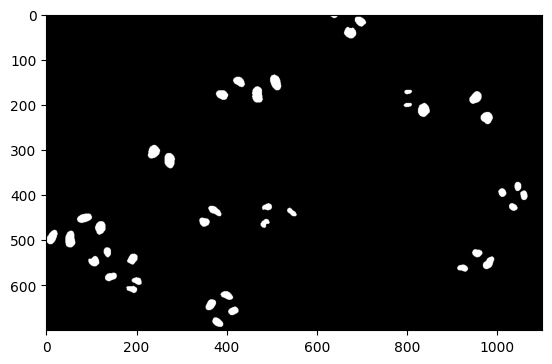

In [14]:
centroids_gray_t13_bilateral, labels_gray_t13_bilateral, clustered_gray_t13_bilateral = kmeans(gray_t13_bilateral, k=2, init_method='kmeans++', space='gray')
centroids_gray_t13_gauß, labels_gray_t13_gauß, clustered_gray_t13_gauß = kmeans(gray_t13_gauß, k=2, init_method='kmeans++', space='gray')
centroids_gray_t13_median, labels_gray_t13_median, clustered_gray_t13_median = kmeans(gray_t13_median, k=2, init_method='kmeans++', space='gray')
centroids_gray_t13, labels_gray_t13, clustered_gray_t13 = kmeans(gray_t13, k=2, init_method='kmeans++', space='gray')

plt.imshow(clustered_gray_t13_median, cmap='gray')

In [ ]:
#save_image_universal(clustered_gray_t13, 'Images/Segmented_Images/t13_for_filterevaluation/clustered_gray_t13_norm.png', space='gray')
#save_image_universal(clustered_gray_t13_bilateral, 'Images/Segmented_Images/t13_for_filterevaluation/clustered_gray_t13_bilateral_norm.png', space='gray')
#save_image_universal(clustered_gray_t13_gauß, 'Images/Segmented_Images/t13_for_filterevaluation/clustered_gray_t13_gauß_norm.png', space='gray')
#save_image_universal(clustered_gray_t13_median, 'Images/Segmented_Images/t13_for_filterevaluation/clustered_gray_t13_median(5)_norm.png', space='gray')

Testing out Thresholding of YeastCells for image segmentation (from KMeans.ipynb)